In [1]:
import tensorflow as tf
import timeit
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import cv2
import random
#!pip install pyod
tf.device('/device:GPU:0')
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')
tf.__version__

Mounted at /content/drive


'2.9.2'

In [2]:
def create_alexnet():

  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
      tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
      tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(4096, activation='relu'),
      tf.keras.layers.Dropout(0.8),
      tf.keras.layers.Dense(4096, activation='relu'),
      tf.keras.layers.Dropout(0.8),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
  #modelAlex.summary()

  return model

### Data loaders

In [4]:
def load_images_preprocess_batch(folder, fnames, resize):
    images = []

    
    for filename in fnames:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = tf.image.per_image_standardization(img)
            img = tf.image.resize(img, (resize, resize))
            images.append(img)
            
    return images


In [5]:
def create_data_set(class_one, class_two):
  label1 = []
  label2 = []


  for i in range(len(class_one)):
    label1.append(1)
    img = class_one[i]
    #img = tf.image.per_image_standardization(img)
    #img = tf.image.resize(img, (227, 227))
    class_one[i] = img


  for i in range(len(class_two)):
    label2.append(0)
    img = class_two[i]
    #img = tf.image.per_image_standardization(img)
    #img = tf.image.resize(img, (227, 227))
    class_two[i] = img

  good_data = (class_one, label1)
  bad_data = (class_two, label2)

  comb_class = class_one + class_two
  comb_lab = label1 + label2

  z = list(zip(comb_class, comb_lab))

  random.shuffle(z)

  comb_class, comb_lab = zip(*z)

  combined_data = (comb_class, comb_lab)

  # need to shuffle

  return combined_data

In [6]:
def divide_data(data, train_perc, test_perc):
  cut_train = int(len(data[0])*train_perc)
  cut_test = int(len(data[0])*(1-test_perc))


  train = (data[0][:cut_train], data[1][:cut_train])
  test = (data[0][cut_train:cut_test], data[1][cut_train:cut_test])
  val = (data[0][cut_test:], data[1][cut_test:])

  return train, test, val

In [7]:
def divide_data_noval(data, train_perc):
  cut_train = int(len(data[0])*train_perc)


  train = (data[0][:cut_train], data[1][:cut_train])
  test = (data[0][cut_train:], data[1][cut_train:])

  return train, test

In [8]:
from sklearn.model_selection import train_test_split
def divide_data_train_test(data, train_perc):

  X_train, X_test, y_train, y_test = train_test_split(data[0], data[1], test_size=1-train_perc, random_state=42, stratify=data[1]) # makes same split everytime
  
  return (X_train, y_train), (X_test, y_test)

In [9]:
folderGood = "drive/My Drive/Masterthesis/data/normal_data"
folderBad = "drive/My Drive/Masterthesis/data/skanner_fake_errors/errors"
fnamesG = list(fname for fname in os.listdir(folderGood))
fnamesB = list(fname for fname in os.listdir(folderBad))

imgsGood = load_images_preprocess_batch(folderGood, fnamesG, 227) # 227 for AlexNet, 224 for DenseNet
imgsBad = load_images_preprocess_batch(folderBad, fnamesB, 227)

dataset = create_data_set(imgsBad, imgsGood)

#train_data_autoenc = fnames[0:int(len(fnames)*0.7)]
#test_data_autoenc = fnames[int(len(fnames)*0.7):]

#print(len(train_data_autoenc), len(test_data_autoenc))

In [10]:
train, test = divide_data_train_test(dataset, 0.7)

In [11]:
def generate_confusion_data(testx, testy, model):
  y_pred = []  # store predicted labels
  y_true = []  # store true labels

  # iterate over the dataset
  for i in range(len(testx)):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(testy[i])
    # compute predictions
    img_tensor = np.expand_dims(testx[i], axis=0)
    preds = model.predict(img_tensor)
    # append predicted labels
    y_pred.append((1 if preds > 0.5 else 0))
    #y_pred.append(preds)

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)

  return (correct_labels, predicted_labels)

In [12]:
def print_cm():
  labels = ["Good data", "Fault data"]

  y_test, y_pred = generate_confusion_data(test_x, test_y)

  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

### Cross validation

In [23]:
def kfold_cross_validation(k = 2):

  validation_accuracy = []
  validation_loss = []
  training_accuracy = []
  training_loss = []
  auc = []
  f1 = []

  skf = StratifiedKFold(n_splits=k)
  skf.get_n_splits(train[0], train[1])
  splitnr = 1

  for train_index, test_index in skf.split(train[0], train[1]):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    print("Starting split ", splitnr)
    splitnr += 1

    X_train, X_test = [train[0][i] for i in train_index], [train[0][i] for i in test_index]
    y_train, y_test = [train[1][i] for i in train_index], [train[1][i] for i in test_index]

    train_x = np.asarray(X_train)
    train_y = np.asarray(y_train)
    validation_x = np.asarray(X_test)
    validation_y = np.asarray(y_test)
    validata = (validation_x, validation_y)


    model = create_alexnet()

    history = model.fit(train_x,
                      train_y,
                      epochs=5,
                      batch_size=32,
                      validation_data=validata,
                      validation_freq=1)
    
    validation_accuracy.append(history.history['val_accuracy'])
    validation_loss.append(history.history['val_loss'])
    training_accuracy.append(history.history['accuracy'])
    training_loss.append(history.history['loss'])

    y_test, y_pred = generate_confusion_data(validation_x, validation_y, model)
    
    auc.append(roc_auc_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))


  return (training_accuracy, validation_accuracy), (training_loss, validation_loss), auc, f1

In [24]:
acc, loss, auc, f1 = kfold_cross_validation()

Starting split  1
Epoch 1/5
4/4 [==============================] - 27s 7s/step - loss: 2.4084 - accuracy: 0.6772 - val_loss: 0.6121 - val_accuracy: 0.8268
Epoch 2/5
4/4 [==============================] - 26s 7s/step - loss: 2.0608 - accuracy: 0.7087 - val_loss: 0.5890 - val_accuracy: 0.8268
Epoch 3/5
4/4 [==============================] - 26s 7s/step - loss: 2.2318 - accuracy: 0.7323 - val_loss: 0.6046 - val_accuracy: 0.8268
Epoch 4/5
4/4 [==============================] - 25s 7s/step - loss: 1.2908 - accuracy: 0.7795 - val_loss: 0.5835 - val_accuracy: 0.8268
Epoch 5/5
1/1 [==============================] - 0s 95ms/step
Starting split  2
Epoch 1/5
4/4 [==============================] - 29s 7s/step - loss: 2.5817 - accuracy: 0.6063 - val_loss: 0.5586 - val_accuracy: 0.8189
Epoch 2/5
4/4 [==============================] - 26s 7s/step - loss: 1.8430 - accuracy: 0.7638 - val_loss: 0.5733 - val_accuracy: 0.8189
Epoch 3/5
4/4 [==============================] - 28s 8s/step - loss: 1.8210 - ac

In [25]:
acc, loss, auc, f1

(([[0.6771653294563293,
    0.7086614370346069,
    0.7322834730148315,
    0.7795275449752808,
    0.8031495809555054],
   [0.6062992215156555,
    0.7637795209884644,
    0.7322834730148315,
    0.7795275449752808,
    0.787401556968689]],
  [[0.8267716765403748,
    0.8267716765403748,
    0.8267716765403748,
    0.8267716765403748,
    0.8976377844810486],
   [0.8188976645469666,
    0.8188976645469666,
    0.8188976645469666,
    0.8188976645469666,
    0.9055117964744568]]),
 ([[2.4083967208862305,
    2.0607552528381348,
    2.231804609298706,
    1.2908122539520264,
    0.985421359539032],
   [2.5816597938537598,
    1.8429739475250244,
    1.820986032485962,
    1.3282129764556885,
    1.2822469472885132]],
  [[0.6120842099189758,
    0.5890284180641174,
    0.6045865416526794,
    0.5834593772888184,
    0.5938582420349121],
   [0.5585650205612183,
    0.5733389258384705,
    0.5657985806465149,
    0.5819184184074402,
    0.6052905321121216]]),
 [0.7045454545454546, 0.739130

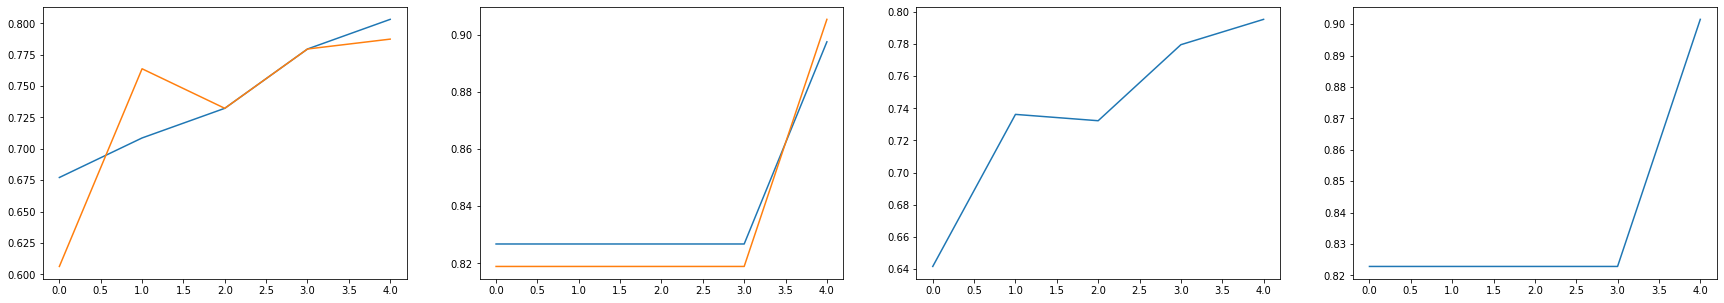

In [41]:
f,ax=plt.subplots(1,4,figsize=(30,5)) 

#for i in range(2):
ax[0].plot(acc[0][0], label='Training accuracy')
ax[0].plot(acc[0][1], label='Training accuracy')
  #ax[0].plot(acc[1][i], label='Validation accuracy')

ax[1].plot(acc[1][0], label='Val accuracy')
ax[1].plot(acc[1][1], label='Val accuracy')

ax[2].plot(np.mean(acc[0], axis=0), label='Train accuracy mean')

ax[3].plot(np.mean(acc[1], axis=0), label='Validation accuracy mean')

#ax[1].plot(np.mean(acc[0], axis=0), label='Validation accuracy mean')
#ax.legend(loc='best')

In [36]:
acc[1][0]

[0.8267716765403748,
 0.8267716765403748,
 0.8267716765403748,
 0.8267716765403748,
 0.8976377844810486]

### Hyperparameter tuning

In [ ]:
def kfold_cross_validation(k = 2):

  validation_accuracy = []
  validation_loss = []
  training_accuracy = []
  training_loss = []
  auc = []
  f1 = []

  skf = StratifiedKFold(n_splits=k)
  skf.get_n_splits(train[0], train[1])
  splitnr = 1

  for train_index, test_index in skf.split(train[0], train[1]):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    print("Starting split ", splitnr)
    splitnr += 1

    X_train, X_test = [train[0][i] for i in train_index], [train[0][i] for i in test_index]
    y_train, y_test = [train[1][i] for i in train_index], [train[1][i] for i in test_index]

    train_x = np.asarray(X_train)
    train_y = np.asarray(y_train)
    validation_x = np.asarray(X_test)
    validation_y = np.asarray(y_test)
    validata = (validation_x, validation_y)


    model = create_alexnet()

    history = model.fit(train_x,
                      train_y,
                      epochs=5,
                      batch_size=16,
                      validation_data=validata,
                      validation_freq=1)
    
    validation_accuracy.append(history.history['val_accuracy'][len(history.history['val_accuracy'])-1])
    validation_loss.append(history.history['val_loss'][len(history.history['val_loss'])-1])
    training_accuracy.append(history.history['accuracy'][len(history.history['accuracy'])-1])
    training_loss.append(history.history['loss'][len(history.history['loss'])-1])

    y_test, y_pred = generate_confusion_data(validation_x, validation_y, model)
    
    auc.append(roc_auc_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))


  return (np.mean(training_accuracy), np.mean(validation_accuracy)), (np.mean(training_loss), np.mean(validation_loss)), np.mean(auc), np.mean(f1)